In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import custom_datagenerator as datagen
from unet_basic import simple_unet_model
import unet_attent

In [2]:
### Get the required paths
# Validation
val_img_path = "data_dir/train_and_val/val/images"
val_mask_path = "data_dir/train_and_val/val/masks"
val_img_list = sorted(os.listdir(val_img_path))
val_mask_list = sorted(os.listdir(val_mask_path))

In [3]:
# Setup the test generator
batch_size = 1
test_img_datagen = datagen.imageLoader(val_img_path, 
                                       val_img_list, 
                                       val_mask_path, 
                                       val_mask_list,
                                       batch_size)

In [4]:
## Load models
modelV1 = load_model("models/brats_3dV1.hdf5", compile=False)
model_attention = load_model("models/brats_3dAttention.hdf5", compile=False)

In [9]:
def calculate_IoU(model, datagenerator, num_images, batch_size):

    number_of_test_images = num_images
    # Initalize arrays to store all actual and all predictions from the generator
    all_actual = np.zeros((number_of_test_images//batch_size, 4, 128, 128, 128))
    all_preds = all_actual

    # Testing the new generator
    for i in range(number_of_test_images//batch_size):
        test_image_batch, test_mask_batch = test_img_datagen.__next__()
        
        test_mask_batch_argmax = np.argmax(test_mask_batch, axis = 4)
        test_pred_batch = model.predict(test_image_batch)
        test_pred_batch_argmax = np.argmax(test_pred_batch, axis = 4)
        
        if test_mask_batch_argmax.shape[0] == 2:
            print(i)
        else:
            all_actual[i] = test_mask_batch_argmax
            all_preds[i] = test_pred_batch_argmax
            
    n_classes = 4
    for i in range(all_actual.shape[0]):
        IoU_vals = tf.metrics.MeanIoU(num_classes=n_classes)
        IoU_vals.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
        if i == 0:
            meanIoU = IoU_vals.result().numpy()
        else:
            meanIoU = (meanIoU + IoU_vals.result().numpy()) / 2
            
    print(f"Mean IoU for {num_images} test images {meanIoU}")
    return meanIoU

In [10]:
meanIoU_V1 = calculate_IoU(modelV1, test_img_datagen, num_images = 86, batch_size = batch_size)

Mean IoU for 86 test images 0.7957305908203125


In [8]:
meanIoU_attention = calculate_IoU(model_attention, test_img_datagen, num_images = 86, batch_size = batch_size)

Mean IoU for all batches of test images 0.8339330554008484


In [32]:
# Predict for a random image
# Select a random image to test
test_img_file = np.random.choice(val_img_list)
# Get the number corresponding to the selected image
test_img_num = filter(str.isdigit, test_img_file)
test_img_num = "".join(test_img_num)

# load that image
test_img = np.load(val_img_path + "/" + test_img_file)
test_mask = np.load(val_mask_path + "/mask_" + str(test_img_num) + ".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = modelV1.predict(test_img_input)
test_prediction_att = model_attention.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]
test_prediction_argmax_attention=np.argmax(test_prediction_att, axis=4)[0,:,:,:]

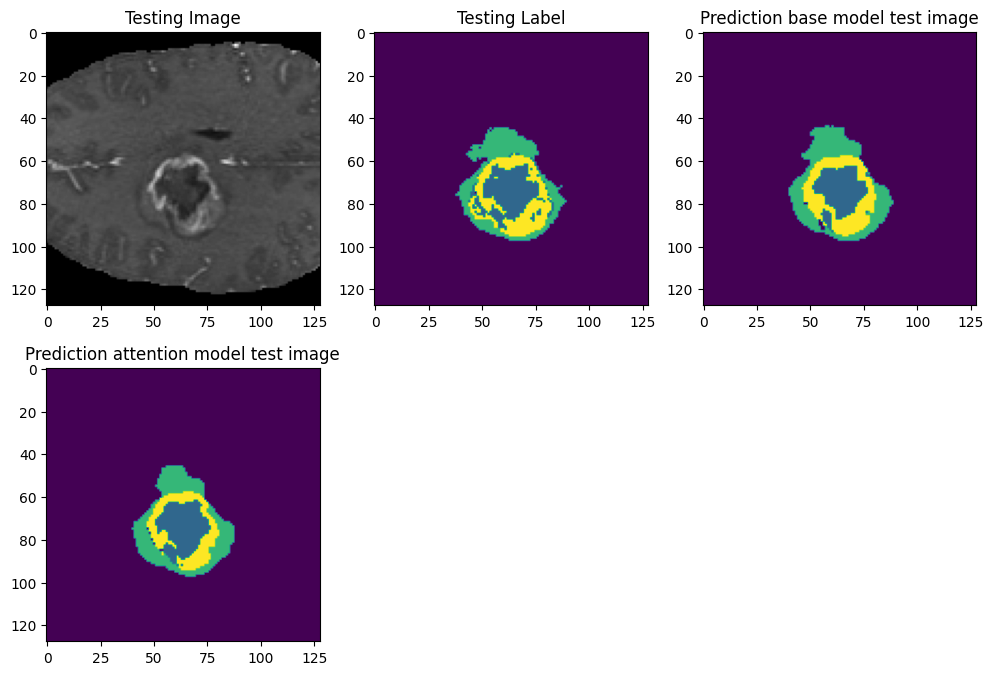

In [33]:
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 80
plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')

plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])

plt.subplot(233)
plt.title('Prediction base model test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])

plt.subplot(234)
plt.title('Prediction attention model test image')
plt.imshow(test_prediction_argmax_attention[:,:, n_slice])
plt.show()